In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools.dist


# Load the processed train and test data
train_data = pd.read_csv("../processed/processed_train_gesture_data.csv")
test_data = pd.read_csv("../processed/processed_test_gesture_data.csv")
hidden_data = pd.read_csv("../processed/processed_hidden_gesture_data.csv")

def str_to_list(s):
    return [float(x.strip()) for x in s.strip('[]').split(',')]

X_train = np.array([str_to_list(row['x']) + str_to_list(row['y']) + str_to_list(row['z']) 
                    for _, row in train_data.iterrows()], dtype=np.float32)
X_test = np.array([str_to_list(row['x']) + str_to_list(row['y']) + str_to_list(row['z'])
                    for _, row in test_data.iterrows()], dtype=np.float32)
X_hidden = np.array([str_to_list(row['x']) + str_to_list(row['y']) + str_to_list(row['z'])
                    for _, row in hidden_data.iterrows()], dtype=np.float32)


# Prepare the labels for training
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['gesture'])
y_test = label_encoder.transform(test_data['gesture'])
y_hidden = label_encoder.transform(hidden_data['gesture'])

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_hidden = X_hidden.reshape(X_hidden.shape[0], 1, X_hidden.shape[1])

# Check the shapes
print(X_train.shape)
print(X_test.shape)
print(X_hidden.shape)
print(y_train.shape)
print(y_test.shape)
print(y_hidden.shape)

print(label_encoder.classes_)


(7125, 1, 120)
(712, 1, 120)
(713, 1, 120)
(7125,)
(712,)
(713,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [12]:
import torch
import onnx
import os
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))


Target device: cpu


In [13]:
from brevitas.nn import QuantConv1d, QuantReLU, QuantLinear, QuantMaxPool1d, QuantDropout
from brevitas.quant import Int8WeightPerTensorFixedPoint, Int8ActPerTensorFixedPoint
import torch.nn as nn
import torch.nn.functional as F
import torch

# Model parameters
input_channels = 1
sequence_length = X_train.shape[2]
conv1_out_channels = 16
conv2_out_channels = 32
fc1_out_features = 64
fc2_out_features = 32
weight_bit_width = 8
act_bit_width = 8
num_classes = len(label_encoder.classes_)

# Define the model
model = nn.Sequential(
    # First Conv1D layer equivalent
    QuantConv1d(
        in_channels=input_channels, out_channels=conv1_out_channels, kernel_size=3, stride=1, padding=1, 
        weight_quant=Int8WeightPerTensorFixedPoint, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(conv1_out_channels),
    QuantReLU(bit_width=act_bit_width),
    QuantMaxPool1d(kernel_size=2, stride=2),

    # Second Conv1D layer equivalent
    QuantConv1d(
        in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=3, stride=1, padding=1, 
        weight_quant=Int8WeightPerTensorFixedPoint, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(conv2_out_channels),
    QuantReLU(bit_width=act_bit_width),
    QuantMaxPool1d(kernel_size=2, stride=2),

    # Flatten layer equivalent
    nn.Flatten(),
    
    # First Dense layer equivalent
    QuantLinear(
        in_features=conv2_out_channels * (sequence_length // 4), out_features=fc1_out_features, 
        weight_quant=Int8WeightPerTensorFixedPoint, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(fc1_out_features),
    QuantReLU(bit_width=act_bit_width),

    # Second Dense layer equivalent
    QuantLinear(
        in_features=fc1_out_features, out_features=fc2_out_features, 
        weight_quant=Int8WeightPerTensorFixedPoint, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(fc2_out_features),
    QuantReLU(bit_width=act_bit_width),

    QuantDropout(p=0.2),
    
    # Output layer equivalent
    QuantLinear(
        in_features=fc2_out_features, out_features=num_classes, 
        weight_quant=Int8WeightPerTensorFixedPoint, bias=True, weight_bit_width=weight_bit_width),
    nn.Softmax(dim=1)
)

# Move model to the appropriate device (CPU/GPU)
model.to(device)


Sequential(
  (0): QuantConv1d(
    1, 16, kernel_size=(3,), stride=(1,), padding=(1,)
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): _StatsSca

In [14]:
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
X_hidden_tensor = torch.tensor(X_hidden, dtype=torch.float32).to(device)
y_hidden_tensor = torch.tensor(y_hidden, dtype=torch.long).to(device)


# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
hidden_dataset = TensorDataset(X_hidden_tensor, y_hidden_tensor)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)

# Create PyTorch dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
hidden_loader = DataLoader(hidden_dataset, batch_size=32, shuffle=False)


torch.Size([7125, 1, 120])
torch.Size([7125])
torch.Size([712, 1, 120])


In [15]:
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
import time

def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

/home/prince/Documents/capstone/Gesture-AI/brevenv/lib/python3.12/site-packages/torch/_tensor.py:1413: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1925.)
  return super().rename(names)


Epoch 1/50
223/223 - 4s 46.7930 - loss: 2.7788 - val_loss: 2.4779 - val_acc: 73.3146
Validation loss decreased (inf --> 2.477949).  Saving model ...
Epoch 2/50
223/223 - 3s 75.2702 - loss: 2.4422 - val_loss: 2.2254 - val_acc: 91.1517
Validation loss decreased (2.477949 --> 2.225421).  Saving model ...
Epoch 3/50
223/223 - 4s 88.8561 - loss: 2.2680 - val_loss: 2.1303 - val_acc: 96.7697
Validation loss decreased (2.225421 --> 2.130327).  Saving model ...
Epoch 4/50
223/223 - 4s 93.2772 - loss: 2.1957 - val_loss: 2.1181 - val_acc: 97.0506
Validation loss decreased (2.130327 --> 2.118066).  Saving model ...
Epoch 5/50
223/223 - 4s 94.4281 - loss: 2.1680 - val_loss: 2.1141 - val_acc: 97.0506
Validation loss decreased (2.118066 --> 2.114103).  Saving model ...
Epoch 6/50
223/223 - 3s 95.2561 - loss: 2.1519 - val_loss: 2.1118 - val_acc: 97.0506
Validation loss decreased (2.114103 --> 2.111824).  Saving model ...
Epoch 7/50
223/223 - 3s 95.3825 - loss: 2.1446 - val_loss: 2.1048 - val_acc: 98.4

/tmp/ipykernel_299815/695585087.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Accuracy on hidden data: 0.9748


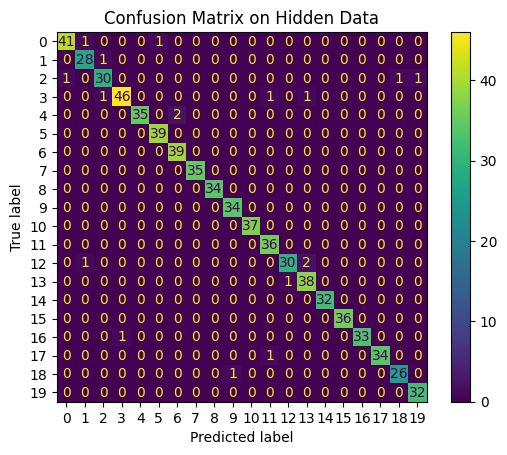

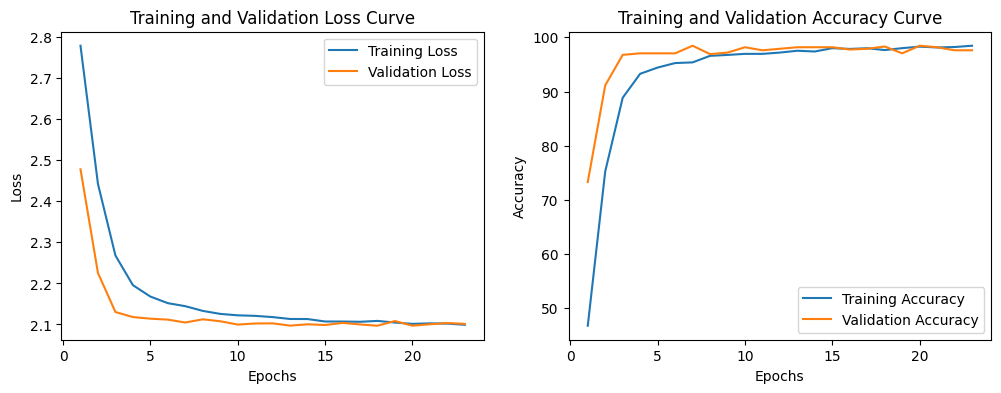

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np

# Define training loop with loss and accuracy tracking
num_epochs = 50
lr = 0.001
l2_reg = 0.00001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)

early_stopping = EarlyStopping(patience=5, verbose=True)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = test(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    epoch_time = time.time() - start_time
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{len(train_loader)}/{len(train_loader)} - {epoch_time:.0f}s {train_acc:.4f} - loss: {train_loss:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
    
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

# After training, test on hidden data
model.eval()
y_true_hidden = []
y_pred_hidden = []

with torch.no_grad():
    for data, target in hidden_loader:
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        y_true_hidden.extend(target.cpu().numpy())
        y_pred_hidden.extend(pred.cpu().numpy())

# Calculate overall accuracy on hidden data
hidden_accuracy = accuracy_score(y_true_hidden, y_pred_hidden)
print(f"Accuracy on hidden data: {hidden_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_hidden, y_pred_hidden)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
cm_display.plot()
plt.title("Confusion Matrix on Hidden Data")
plt.show()

# Plot Loss and Validation Accuracy
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()

# Validation accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curve')
plt.legend()

plt.show()

In [17]:
# import torch
# import torch.nn as nn

# class ModelWithPrint(nn.Module):
#     def __init__(self):
#         super(ModelWithPrint, self).__init__()
#         self.conv1 = QuantConv1d(
#             in_channels=input_channels, out_channels=conv1_out_channels, kernel_size=3, stride=1, padding=1, 
#             weight_quant=Int8WeightPerTensorFixedPoint, bias=True, weight_bit_width=weight_bit_width)
#         self.bn1 = nn.BatchNorm1d(conv1_out_channels)
#         self.relu1 = QuantReLU(bit_width=act_bit_width)
#         self.pool1 = QuantMaxPool1d(kernel_size=2, stride=2)

#         self.conv2 = QuantConv1d(
#             in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=3, stride=1, padding=1, 
#             weight_quant=Int8WeightPerTensorFixedPoint, bias=True, weight_bit_width=weight_bit_width)
#         self.bn2 = nn.BatchNorm1d(conv2_out_channels)
#         self.relu2 = QuantReLU(bit_width=act_bit_width)
#         self.pool2 = QuantMaxPool1d(kernel_size=2, stride=2)

#         self.flatten = nn.Flatten()
#         self.fc1 = QuantLinear(
#             in_features=conv2_out_channels * (sequence_length // 4), out_features=fc1_out_features, 
#             weight_quant=Int8WeightPerTensorFixedPoint, bias=True, weight_bit_width=weight_bit_width)
        
#         # Updated to use nn.BatchNorm1d directly on the features after flattening
#         self.bn3 = nn.BatchNorm1d(fc1_out_features)
#         self.relu3 = QuantReLU(bit_width=act_bit_width)

#         self.fc2 = QuantLinear(
#             in_features=fc1_out_features, out_features=fc2_out_features, 
#             weight_quant=Int8WeightPerTensorFixedPoint, bias=True, weight_bit_width=weight_bit_width)
#         self.bn4 = nn.BatchNorm1d(fc2_out_features)
#         self.relu4 = QuantReLU(bit_width=act_bit_width)

#         self.dropout = QuantDropout(p=0.2)

#         self.fc3 = QuantLinear(
#             in_features=fc2_out_features, out_features=num_classes, 
#             weight_quant=Int8WeightPerTensorFixedPoint, bias=True, weight_bit_width=weight_bit_width)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         print(f"Input shape: {x.shape}")
#         x = self.conv1(x)
#         print(f"After conv1: {x.shape}")
#         x = self.bn1(x)
#         print(f"After bn1: {x.shape}")
#         x = self.relu1(x)
#         print(f"After relu1: {x.shape}")
#         x = self.pool1(x)
#         print(f"After pool1: {x.shape}")

#         x = self.conv2(x)
#         print(f"After conv2: {x.shape}")
#         x = self.bn2(x)
#         print(f"After bn2: {x.shape}")
#         x = self.relu2(x)
#         print(f"After relu2: {x.shape}")
#         x = self.pool2(x)
#         print(f"After pool2: {x.shape}")

#         x = self.flatten(x)
#         print(f"After flatten: {x.shape}")

#         x = self.fc1(x)
#         print(f"After fc1: {x.shape}")
#         x = self.bn3(x)  # Now batch norm should work as it operates on features
#         print(f"After bn3: {x.shape}")
#         x = self.relu3(x)
#         print(f"After relu3: {x.shape}")

#         x = self.fc2(x)
#         print(f"After fc2: {x.shape}")
#         x = self.bn4(x)
#         print(f"After bn4: {x.shape}")
#         x = self.relu4(x)
#         print(f"After relu4: {x.shape}")

#         x = self.dropout(x)
#         print(f"After dropout: {x.shape}")

#         x = self.fc3(x)
#         print(f"After fc3: {x.shape}")
#         x = self.softmax(x)
#         print(f"After softmax: {x.shape}")

#         return x

# # Example usage
# model_with_print = ModelWithPrint().to(device)

# # Dummy input to pass through the model to check layer dimensions
# dummy_input = torch.randn(1, 1, sequence_length).to(device)
# output = model_with_print(dummy_input)


In [19]:

from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

ready_model_filename = "../model_dir/gesture.onnx"

input_shape = (1, sequence_length)  # Adjust according to your input size
input_a = np.random.uniform(-1, 1, size=input_shape).astype(np.float32)
input_t = torch.from_numpy(input_a)


# Move the model to CPU before surgery
model = model.cpu()

# Move to CPU before export
model.cpu()

# Export to ONNX
export_qonnx(
    model, export_path=ready_model_filename, input_t=input_t
)

# Clean-up
qonnx_cleanup(ready_model_filename, out_file=ready_model_filename)

# ModelWrapper
model = ModelWrapper(ready_model_filename)

# Set input datatype to FLOAT32
model.set_tensor_datatype(model.graph.input[0].name, DataType["FLOAT32"])
model = model.transform(ConvertQONNXtoFINN())
model.save(ready_model_filename)

print("Model saved to %s" % ready_model_filename)




ModuleNotFoundError: No module named 'finn.transformation'